In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
task1 = pd.read_csv('task1_dataset.csv')

In [5]:
poi = pd.read_csv('cell_POIcat.csv')

In [91]:
task1_night = task1[(task1['t'] <= 13) | (task1['t'] >= 38)]
task1_night_count = task1_night.groupby(['uid', 'x', 'y']).count().reset_index()
home_idx = task1_night_count.groupby(['uid'])['t'].idxmax()
home_locations = task1_night_count.loc[home_idx,:]
home_locations = home_locations[home_locations['x'] < 250].reset_index(drop=True)


In [93]:
task1_day = task1[(task1['t'] > 13) & (task1['t'] < 38)]
task1_day_count = task1_day.groupby(['uid', 'x', 'y']).count().reset_index()
work_idx = task1_day_count.groupby(['uid'])['t'].idxmax()
work_locations = task1_day_count.loc[work_idx,:]
work_locations = work_locations[work_locations['x'] < 250].reset_index(drop=True)


In [286]:
users = np.array(list(set(home_locations['uid']).intersection(set(work_locations['uid']))))

<AxesSubplot:xlabel='POIcategory', ylabel='Count'>

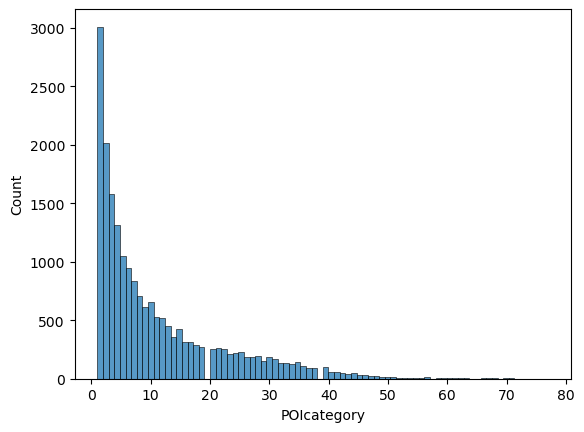

In [39]:
num_poi_cat = poi.groupby(['x','y'])['POIcategory'].nunique().reset_index()['POIcategory']
sns.histplot(num_poi_cat)

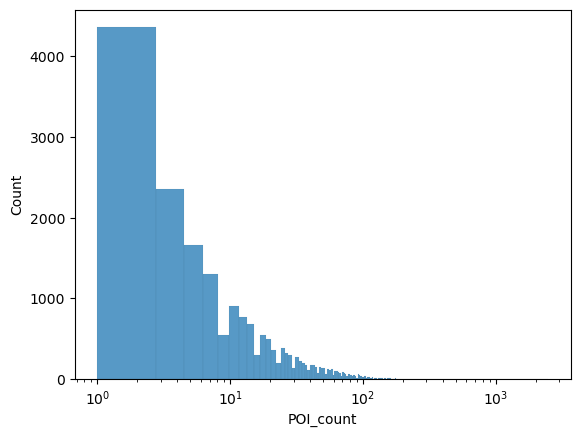

In [45]:
num_poi = poi.groupby(['x','y'])['POI_count'].sum().reset_index()['POI_count']
sns.histplot(num_poi)
plt.xscale('log')

Text(0.5, 1.0, 'Work Location Density')

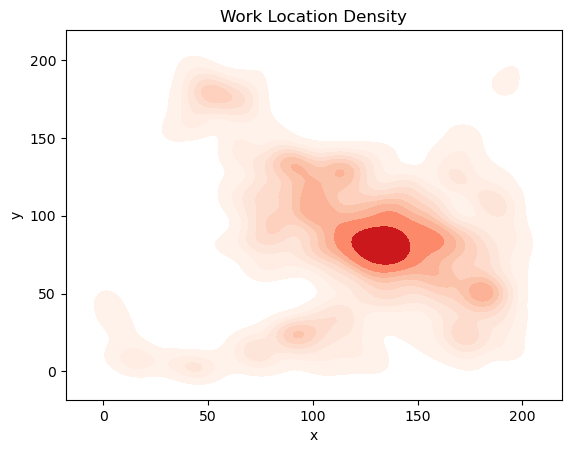

In [24]:
import seaborn as sns
sns.kdeplot(x=home_locations['x'], y=home_locations['y'], cmap="Reds", fill=True)
plt.title('Work Location Density')

In [70]:
poi_idx = poi.groupby(['x','y'])['POI_count'].idxmax()

In [72]:
poi_cleaned = poi.loc[poi_idx,:].reset_index(drop=True)

In [334]:
poi['POI_count'].sum()

495171

In [378]:
poi

,x,y,POIcategory,POI_count
0,1,1,48,4
1,1,1,58,1
2,1,1,59,1
3,1,1,69,2
4,1,1,73,1
...,...,...,...,...
221154,200,200,75,2
221155,200,200,76,1
221156,200,200,78,1
221157,200,200,79,1


In [348]:
poi_cleaned.groupby('POIcategory').count().sort_values('x', ascending=False).head(20)

,x,y,POI_count
POIcategory,,,
81,2942,2942,2942
59,2729,2729,2729
74,1805,1805,1805
48,1686,1686,1686
60,1261,1261,1261
47,992,992,992
69,789,789,789
79,704,704,704
63,557,557,557


In [ ]:
def most_frequent_in_columns(arr):
    result = []
    for col in range(arr.shape[1]):
        values, counts = np.unique(arr[:, col], return_counts=True)
        most_frequent_value = values[np.argmax(counts)]
        result.append(most_frequent_value)
    result = np.array(result)
    return result

In [297]:
from tqdm import tqdm

data = np.zeros(shape=(task1['uid'].nunique(), 48), dtype=str)

for i in tqdm(users):
    # select the user's record and find his home and work
    temp = task1[task1['uid'] == i]
    home_x = home_locations[home_locations['uid'] == i]['x'].values
    home_y = home_locations[home_locations['uid'] == i]['y'].values
    work_x = work_locations[work_locations['uid'] == i]['x'].values
    work_y = work_locations[work_locations['uid'] == i]['y'].values

    # parse the trajectories by filling the gaps
    xmat = np.zeros(shape=(75*48,))
    ymat = np.zeros(shape=(75*48,))
    idx = 0
    for row in range(temp.shape[0]):
        d = temp.iloc[row,:]['d']
        t = temp.iloc[row,:]['t']
        x = temp.iloc[row,:]['x']
        y = temp.iloc[row,:]['y']


        xmat[idx : d*48+t] = x
        ymat[idx : d*48+t] = y
        idx = d*48+t
    xmat[idx:] = x
    ymat[idx:] = y

    # find a typical trajectory of the user
    typical_x = most_frequent_in_columns(xmat.reshape(75,48))
    typical_y = most_frequent_in_columns(ymat.reshape(75,48))

    typical = pd.DataFrame({'x':typical_x, 'y':typical_y}, dtype=int)
    typical = typical.merge(poi_cleaned, how='left', on=['x', 'y'])
    home_for_user = (typical['x'] == int(home_x)) & (typical['y'] == int(home_y))
    typical.loc[home_for_user, 'POIcategory'] = 'home'
    work_for_user = (typical['x'] == int(work_x)) & (typical['y'] == int(work_y))
    typical.loc[work_for_user, 'POIcategory'] = 'work'

    data[i,:] = typical['POIcategory'].to_numpy()
    

100%|██████████| 85614/85614 [3:25:46<00:00,  6.93it/s]  


In [298]:
np.save('input_with_poi.npy', data)

In [299]:
data

array([['5', '5', '5', ..., '5', 'h', 'h'],
       ['w', 'h', 'h', ..., 'h', 'h', 'h'],
       ['h', 'h', '6', ..., 'h', 'h', 'h'],
       ...,
       ['w', 'w', 'w', ..., 'w', 'w', 'w'],
       ['w', 'w', 'w', ..., 'w', 'w', 'w'],
       ['4', '4', '4', ..., 'n', '6', 'n']], dtype='<U1')

In [319]:

from kmodes.kmodes import KModes
cost = []
K = range(1,11)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "random")
    kmode.fit_predict(data)
    cost.append(kmode.cost_)

In [379]:
kmode = KModes(n_clusters=5, init = "random")
predicted_mode = kmode.fit_predict(data)

In [368]:
kmode.cluster_centroids_

array([['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w'],
       ['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h',
        'h', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'h', 'h', 'h', 'h', 'h',
        'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
       ['5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5',
        '5', '5', '5', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', '5', '5', '5', '5', '5',
        '5', '5', 

In [376]:
np.mean(predicted_mode == 2)

0.27166

In [ ]:
# select the next cell based on the relative density of the poi (based on the number of visits)
# cells with poi 5
# exploration vs. return (20%? new cell)

Text(0, 0.5, 'Explained Variance')

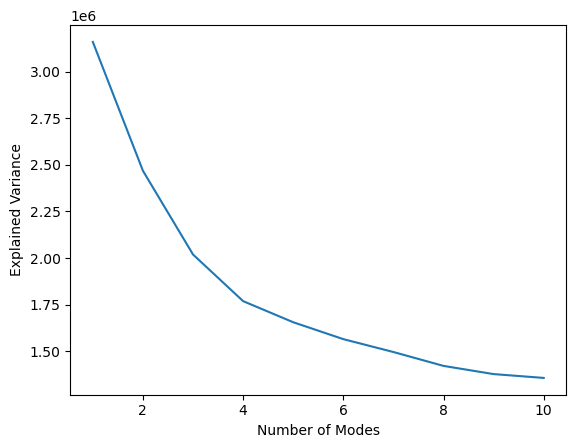

In [377]:
plt.plot(np.arange(1,11), cost)
plt.title('')
plt.xlabel('Number of Modes')
plt.ylabel('Explained Variance')

### Find users that are predictable and replace prediction with historical data

### Distribution of departure time for each user


In [8]:
poi['POIcategory'].nunique()

85

In [11]:
record_dist = task1.groupby('uid').count().reset_index()['d'].to_numpy()

Text(0.5, 1.0, 'Distribution of # of Records')

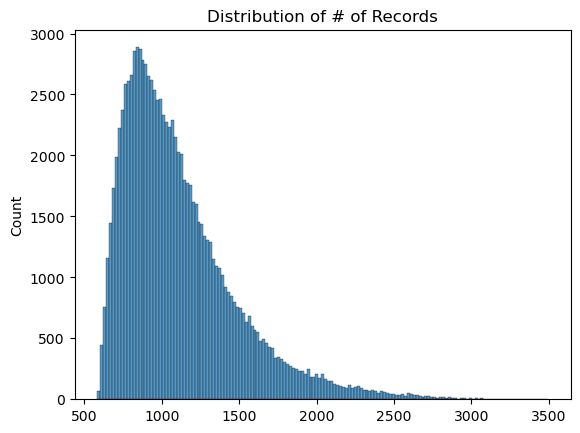

In [16]:
sns.histplot(record_dist)
plt.title('Distribution of # of Records')

In [22]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the location of Sacramento
latitude = 38.5816
longitude = -121.4944
distance = 5000  # Define a distance (in meters) to get the area around Sacramento

# Get the street network and transit lines data for Sacramento
G = ox.graph_from_point((latitude, longitude), network_type='all', simplify=True)

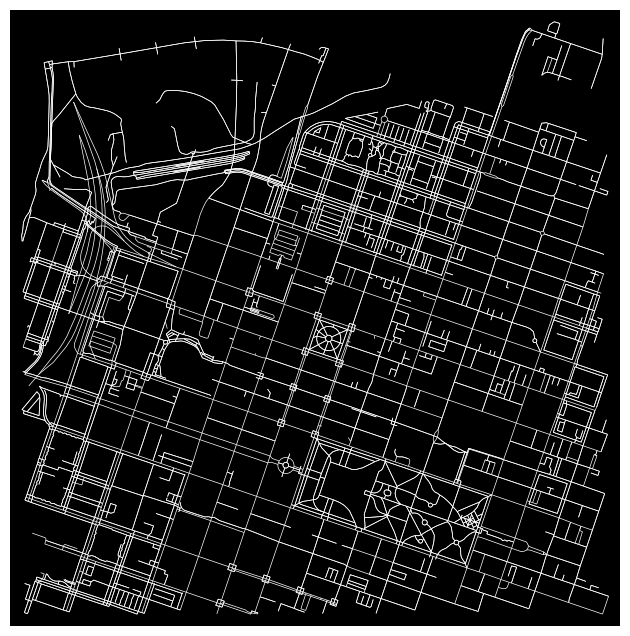

TypeError: plot_footprints() got an unexpected keyword argument 'fig'

In [21]:
# Plot the street network
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, edge_color='w', bgcolor='k')

# Plot the transit lines
transit_lines = ox.plot_footprints(G, fig=fig, ax=ax, show=False, close=False, color='blue', alpha=0.7)

# Display the map
plt.show()